# Tasks
- Data preparation and data cleaning
- EDA, feature importance analysis
- Model selection process and parameter tuning

In [4]:
#import pandas as pd
import numpy as np
#import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2023-12-14 19:53:39.642684: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 19:53:41.351600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 19:53:41.351702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 19:53:41.614777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 19:53:42.316137: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 19:53:42.320668: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Loading a sample image


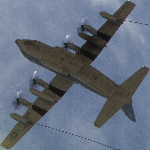

In [2]:
path = './../Data/train/C130/'
name = '753eb1be41c9cedff339be099cdd7ee9_0.jpg'
fullname = f'{path}/{name}'
#load_img(fullname)

img = load_img(fullname, target_size=(150, 150))
img


# Helper functions

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [6]:
def show_images(generator, num_images_per_class=1, normalized=False):
    class_names = list(generator.class_indices.keys())
    directory = generator.directory

    plt.figure(figsize=(15, 3 * len(class_names)))

    for i, class_name in enumerate(class_names):
        plt.subplot(len(class_names), num_images_per_class, i * num_images_per_class + 1)
        
        # Collecting images of one class
        class_path = os.path.join(directory, class_name)
        image_files = os.listdir(class_path)
        image_files = np.random.choice(image_files, num_images_per_class, replace=False)

        for j, image_file in enumerate(image_files):
            plt.subplots_adjust(hspace=0.5)
            plt.subplot(len(class_names), num_images_per_class, i * num_images_per_class + j + 1)
            
            img_path = os.path.join(class_path, image_file)

            if normalized:
                img = image.load_img(img_path, target_size=(150, 150))
            else:
                img = image.load_img(img_path)
            
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            plt.imshow(img_array[0])
            plt.axis('off')
            plt.title(f'Class: {class_name}')

    plt.tight_layout()
    plt.show()


In [7]:
def plot_count(generator):
    aircraft_counts = {}
    
    for aircraft_label in generator.class_indices.keys():
        aircraft_counts[aircraft_label] = generator.classes.tolist().count(generator.class_indices[aircraft_label])
    
    plt.figure(figsize=(10, 6))
    plt.bar(aircraft_counts.keys(), aircraft_counts.values(), color='skyblue')
    plt.xlabel('Aircraft Types')
    plt.ylabel('Image Count')
    plt.title('Image Count of Class')
    plt.show()

In [8]:
def test_model(image_data_generator, model):
    predictions = []

    for subdir in os.listdir(image_data_generator.directory):
        subdir_path = os.path.join(image_data_generator.directory, subdir)
        
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                file_size = os.path.getsize(file_path)
                
                # Loading and pre processing image
                img = image.load_img(file_path, target_size=image_data_generator.image_shape)
                img_array = np.array(img, dtype="float32") / 255.0
                img_array = img_array.reshape((1,) + img_array.shape)

                # Predicting the label of that image
                prediction = model.predict(img_array)[0]

                # Saving the index with the highest probability
                predicted_class_index = np.argmax(prediction)
                predicted_class_name = list(image_data_generator.class_indices.keys())[predicted_class_index]

                # Saving the results
                result = {
                    'File Name': file,
                    'File Size': file_size,
                    'Aircraft type (Ground Truth)': subdir,
                    'Aircraft type (Prediction)': predicted_class_name,
                    **{f'Probability ({class_name})': f'{prob:.5%}' for class_name, prob in zip(image_data_generator.class_indices.keys(), prediction)}
                }
                predictions.append(result)

    # Creating Pandas DataFrame 
    predictions_df = pd.DataFrame(predictions)
    return predictions_df

In [9]:
def get_ImageDataGenerators():

    train_gen = ImageDataGenerator(rescale=1./255)

    train_generator = train_gen.flow_from_directory(
        './../Data/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    test_generator = test_gen.flow_from_directory(
        './../Data/test',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )

    return train_generator, test_generator

In [10]:
def output_acc_per_class(test_image_data_generator, test_predictions):
    for aircraft_type in test_image_data_generator.class_indices:
        count = test_image_data_generator.classes.tolist().count(test_image_data_generator.class_indices[aircraft_type])
        aircraft_set = test_predictions[test_predictions['Aircraft type (Ground Truth)'] == aircraft_type]
        acc = np.sum(aircraft_set['Aircraft type (Ground Truth)'] == aircraft_set['Aircraft type (Prediction)']) / count
        print(f'{aircraft_type} Accuracy: {acc:.4f}')

# Looking at the data

In [113]:
train_generator, test_generator = get_ImageDataGenerators()

Found 1770 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [119]:
print("Class count in train path:",len(list(train_generator.class_indices.keys())))
print("Classes in train path:", list(train_generator.class_indices.keys()))

print("Class count in test path:",len(list(test_generator.class_indices.keys())))
print("Classes in test path:", list(test_generator.class_indices.keys()))

Class count in train path: 4
Classes in train path: ['A400M', 'C130', 'Su57', 'Tu160']
Class count in test path: 4
Classes in test path: ['A400M', 'C130', 'Su57', 'Tu160']


## Training Set

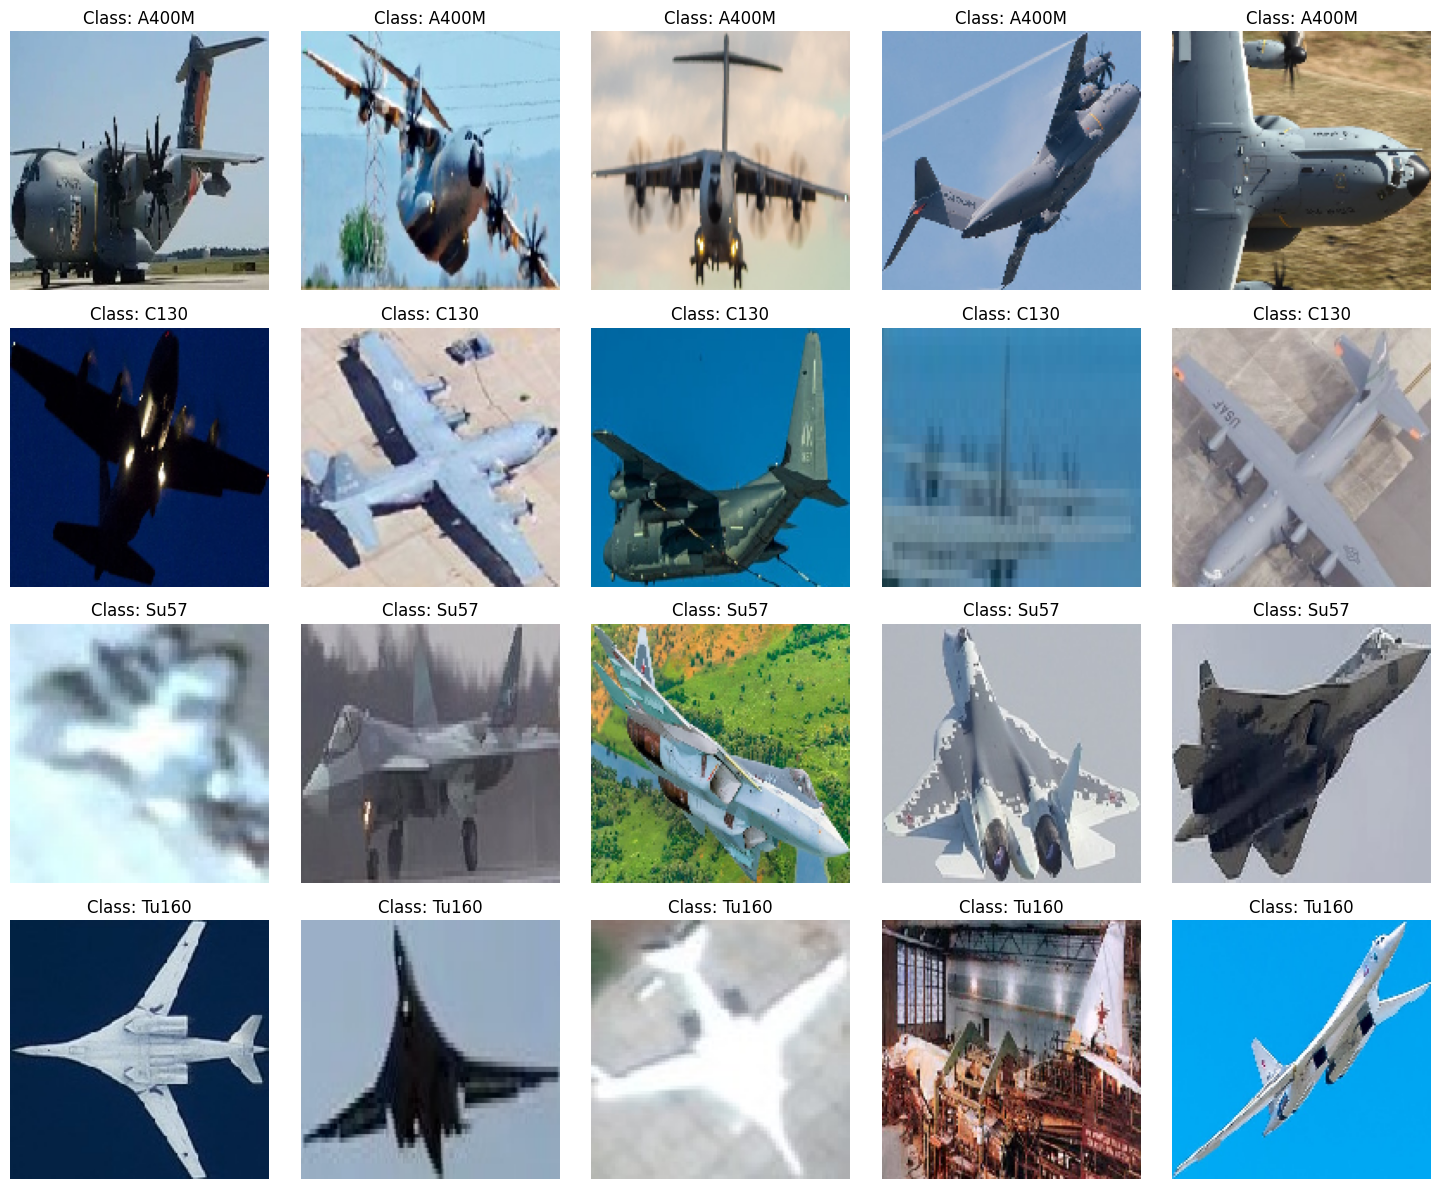

In [107]:
show_images(train_generator, 5, True)

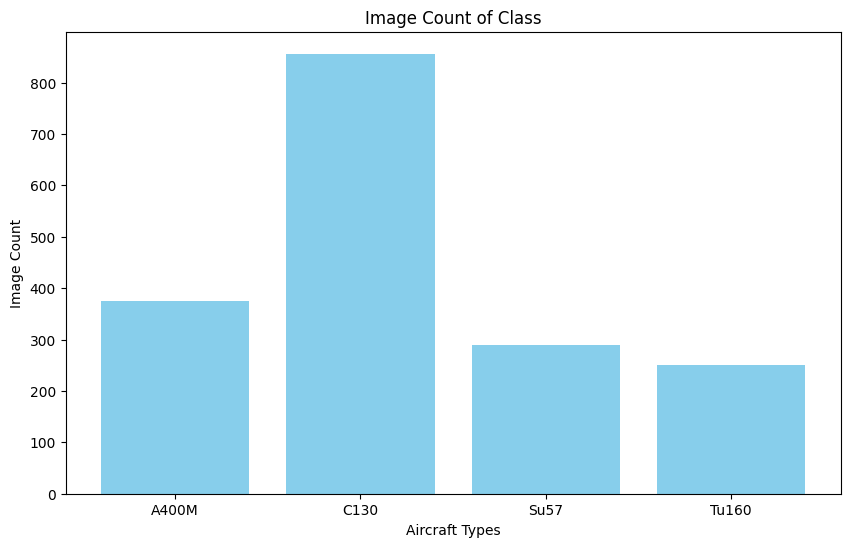

In [10]:
plot_count(train_generator)

## Test set

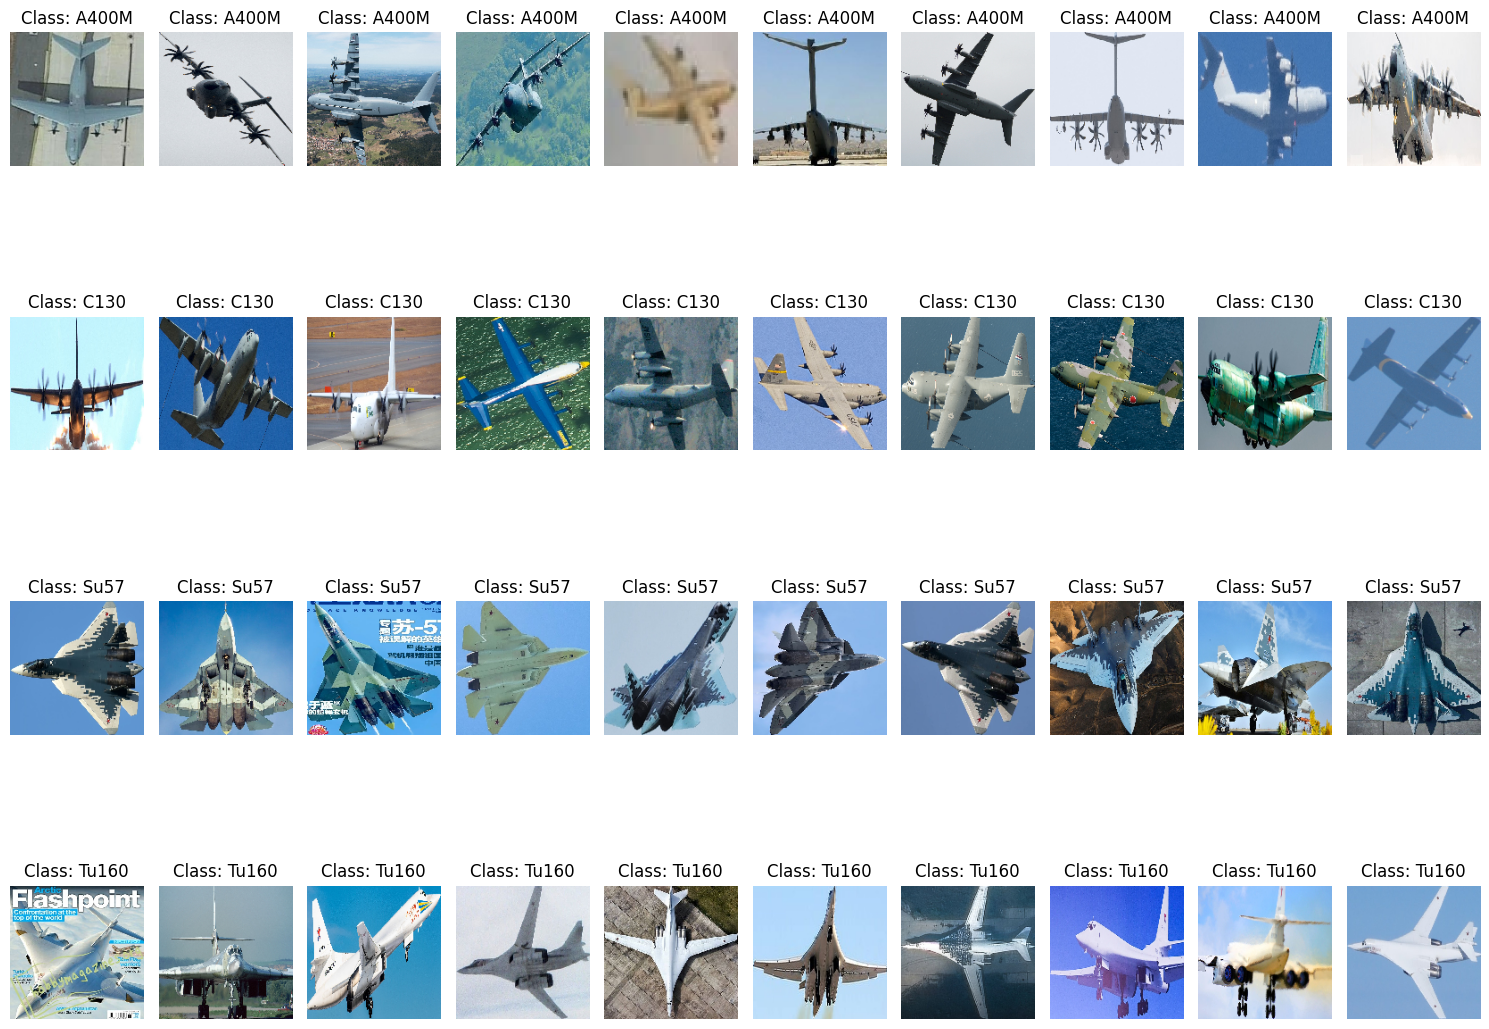

In [159]:
show_images(test_generator, 10, True)

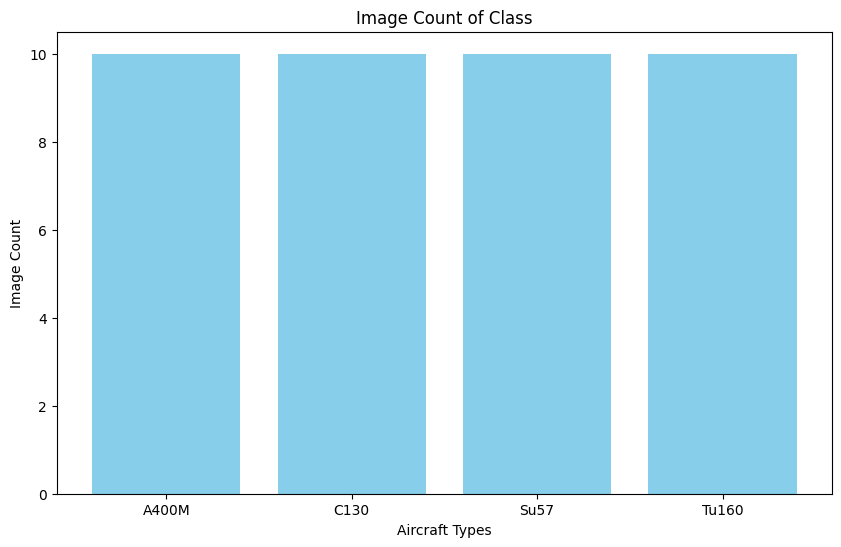

In [11]:
plot_count(test_generator)

# Basic Model

In [146]:
input_size=150
base_model = keras.models.Sequential()
classes = len(list(train_generator.class_indices.keys()))

inputs = keras.Input(shape=(input_size, input_size, 3))
base = base_model(inputs)

conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(vectors_1)
vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
flatten = keras.layers.Flatten()(vectors_2)
dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
outputs = keras.layers.Dense(classes, activation='softmax')(dense_1)

model_basic = keras.Model(inputs, outputs)

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
loss = keras.losses.CategoricalCrossentropy()

model_basic.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
)

model_basic.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_8 (Sequential)   multiple                  0         
                                                                 
 conv2d_23 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                     

In [147]:
history = model_basic.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
89/89 [==============================] - 54s 589ms/step - loss: 1.2695 - accuracy: 0.4729 - val_loss: 1.6161 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 53s 589ms/step - loss: 1.2455 - accuracy: 0.4836 - val_loss: 1.4714 - val_accuracy: 0.2500
Epoch 3/10
89/89 [==============================] - 50s 563ms/step - loss: 1.2260 - accuracy: 0.4893 - val_loss: 1.4526 - val_accuracy: 0.2500
Epoch 4/10
89/89 [==============================] - 46s 509ms/step - loss: 1.1928 - accuracy: 0.4983 - val_loss: 1.3726 - val_accuracy: 0.3250
Epoch 5/10
89/89 [==============================] - 52s 583ms/step - loss: 1.1613 - accuracy: 0.5164 - val_loss: 1.3087 - val_accuracy: 0.4000
Epoch 6/10
89/89 [==============================] - 52s 580ms/step - loss: 1.1376 - accuracy: 0.5232 - val_loss: 1.2601 - val_accuracy: 0.5250
Epoch 7/10
89/89 [==============================] - 51s 570ms/step - loss: 1.1052 - accuracy: 0.5407 - val_loss: 1.2564 - val_accuracy: 0.3500

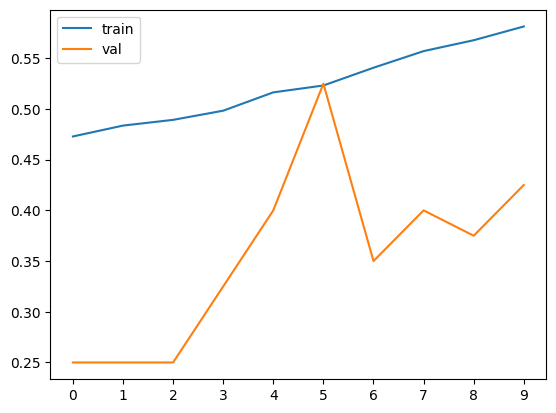

In [148]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

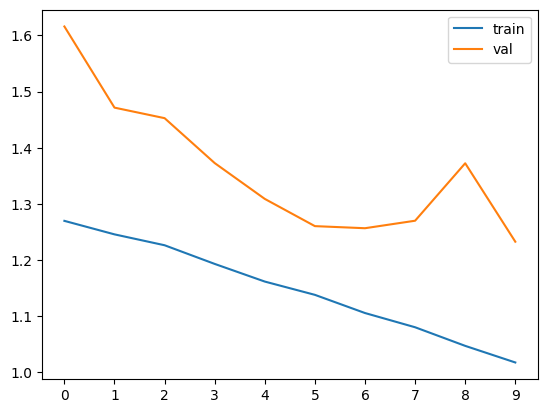

In [149]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [150]:
classes = list(test_generator.class_indices.keys())
classes

['A400M', 'C130', 'Su57', 'Tu160']

In [151]:
test_predictions = test_model(test_generator, model_basic)
test_predictions

1/1 [==============================] - 0s 64ms/step


File Name  File Size  \
0   75564e9f3f17c7874e5260a4a3cec8ee_2.jpg      42941   
1   b666267f2b0cd31cf358778b1158ec81_0.jpg       1913   
2   677e0eb8e32a5074bfd8130e9679f92e_0.jpg     263860   
3   972038762c34b66caaef598bdd61a48b_0.jpg      24251   
4   6deae45660f7f28c6faa4e47d15500a3_2.jpg      39293   
5   9c68108b79fa87e30de6ba6609c97d22_0.jpg    1116801   
6   a6df7d22743528a49e815e81cc5e96c5_0.jpg      41354   
7   d9c7496d22a0c903157077997495541d_2.jpg      27306   
8   254388ed068c3e116c368f2b22343ec5_0.jpg    1353618   
9   cb00888189e2a56640e4a98b40c9d909_1.jpg      24279   
10  b6e8a7954e3e906f6779f40caa082bb3_0.jpg    1212324   
11  893ed36b443cc9b0e7b244ced87a65c9_0.jpg     165532   
12  341e68a0c63b6b7681233c4324fbca79_0.jpg      82457   
13  a3dccd36c4a68de45520c57517464ed2_0.jpg     114468   
14  bff74276f9195233b82fe8780d656f10_2.jpg     153865   
15  8c522c3774c3a64720341b48165210aa_0.jpg      77004   
16  18121db1452fd759adb4f51a01adb2ab_0.jpg     198287   
17  3d23841d25007c85d13b2e663321ad39_4.jpg     491397   
18  47fd84d4bfc5ac09f762a999756b7bc3_0.jpg      66067   
19  031726327f5f51788fbf03a1dc69527d_0.jpg     133210   
20  82fb466dc9a61953bc4e1267ab3691aa_0.jpg      83004   
21  8d6141670cc7a7894a789a91d461413c_3.jpg     153741   
22  697ba3e167a92fead0b4514bd14b9f5c_0.jpg     130950   
23  0c02addad95322392e327032a3b0d2b2_0.jpg     656237   
24  cf0c2a3be99325f5bae7118c525be8b0_0.jpg     631170   
25  50f7a0b92a276b000c0fe6905d1d3614_0.jpg     294634   
26  2cbe25b281bab1a4f3a7029c44bac3c5_0.jpg     147847   
27  6c619d7818b1eeefda7a3e79c5795347_0.jpg      37599   
28  4f6335afb880904ed5ebae7ed55fd81b_0.jpg      25335   
29  28b5bff3e86f8dae8d1333279b4fba31_0.jpg     190966   
30  cd152d7c293d3cbd44fd323535610975_0.jpg     175948   
31  cf203d5421aef5176ec086730e3cbada_0.jpg     111856   
32  c2b8ce926662b1f8af69f89ac1256c01_0.jpg     303860   
33  dbc90c8aae7e2ccd83915a314a95252e_0.jpg     263728   
34  30aaf62a22cd2dde0aa90614da20172c_0.jpg     591787   
35  6ab2a802b87934018935a4388aa9176b_0.jpg     127376   
36  86011f1f186389d7bebf2c6357106160_0.jpg     139766   
37  2a735ee961ce7fabe6c6217f3a3ef53b_0.jpg      77558   
38  495fada28cab24907fda48ac6d964007_0.jpg      75487   
39  73cea06069b9d1f0745a3de4d336bd90_1.jpg      91321   

   Aircraft type (Ground Truth) Aircraft type (Prediction)  \
0                         A400M                       C130   
1                         A400M                       C130   
2                         A400M                       C130   
3                         A400M                       C130   
4                         A400M                       C130   
5                         A400M                       Su57   
6                         A400M                       C130   
7                         A400M                       C130   
8                         A400M                      A400M   
9                         A400M                       C130   
10                         C130                       C130   
11                         C130                       C130   
12                         C130                       C130   
13                         C130                       C130   
14                         C130                       C130   
15                         C130                       Su57   
16                         C130                       C130   
17                         C130                       C130   
18                         C130                       C130   
19                         C130                       C130   
20                        Tu160                       C130   
21                        Tu160                       C130   
22                        Tu160                      Tu160   
23                        Tu160                       C130   
24                        Tu160                      Tu160   
25                        Tu160                       C130   
26                   

In [153]:
filenames = test_generator.filenames
num_samples = len(filenames)
accuracy = np.sum(test_predictions['Aircraft type (Ground Truth)'] == test_predictions['Aircraft type (Prediction)']) / num_samples
print(f'Overall Accuracy: {accuracy:.4f}')

Overall Accuracy: 0.4250


In [158]:
output_acc_per_class(test_generator, test_predictions)

A400M Accuracy: 0.1000
C130 Accuracy: 0.9000
Su57 Accuracy: 0.4000
Tu160 Accuracy: 0.3000


As expected we can see the very poor performance on the test set. Regarding the very good accuracy for "C130" aircraft type, this is also expected, because of the imbalance of the training dataset. There are the most images in the C130 folder. I need to train an improved model.

# Improved model

In [13]:
input_size=150
base_model = keras.models.Sequential()
classes = len(list(train_generator.class_indices.keys()))

inputs = keras.Input(shape=(input_size, input_size, 3))
base = base_model(inputs)

# Stack of convolutional layers and pooling layers
conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

# Flatten Layer
flatten = keras.layers.Flatten()(vectors_3)

# Fully Connected Layers
dense_1 = keras.layers.Dense(256, activation='relu')(flatten)
#drop_1 = keras.layers.Dropout(rate=0.45, seed=150)(dense_1)
dense_2 = keras.layers.Dense(128, activation='relu')(dense_1)
#drop_1 = keras.layers.Dropout(rate=0.45, seed=150)(dense_2)

# Output Layer
outputs = keras.layers.Dense(classes, activation='softmax')(dense_2)

model1 = keras.Model(inputs, outputs)

loss = keras.losses.CategoricalCrossentropy()

model1.compile(
    #optimizer='rmsprop',
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                        

In [ ]:
load_img('./../Images/improved_model.jpg')

In [14]:
history = model1.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
89/89 [==============================] - 107s 1s/step - loss: 1.2951 - accuracy: 0.4701 - val_loss: 1.5326 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 88s 988ms/step - loss: 1.1628 - accuracy: 0.5051 - val_loss: 1.5469 - val_accuracy: 0.3250
Epoch 3/10
89/89 [==============================] - 96s 1s/step - loss: 0.8891 - accuracy: 0.6480 - val_loss: 1.1314 - val_accuracy: 0.5500
Epoch 4/10
89/89 [==============================] - 89s 998ms/step - loss: 0.5808 - accuracy: 0.7836 - val_loss: 0.8544 - val_accuracy: 0.6750
Epoch 5/10
89/89 [==============================] - 83s 926ms/step - loss: 0.2754 - accuracy: 0.9051 - val_loss: 1.0034 - val_accuracy: 0.6750
Epoch 6/10
89/89 [==============================] - 81s 910ms/step - loss: 0.1337 - accuracy: 0.9565 - val_loss: 1.4538 - val_accuracy: 0.6250
Epoch 7/10
89/89 [==============================] - 81s 902ms/step - loss: 0.1087 - accuracy: 0.9655 - val_loss: 1.2364 - val_accuracy: 0.6750
Epoc

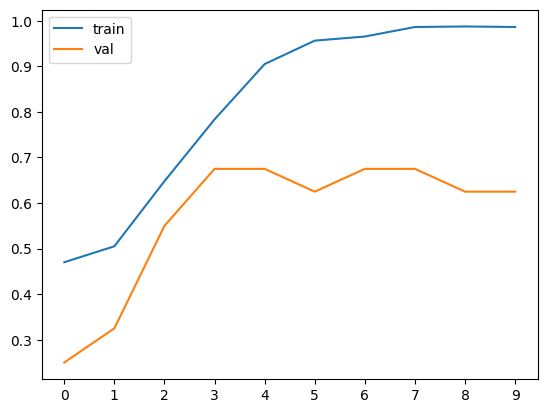

In [15]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

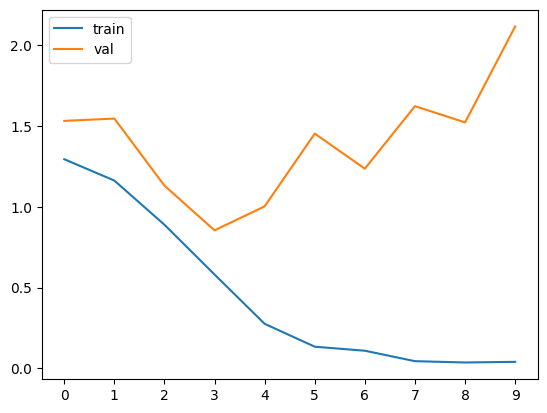

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Evaluation improved model

In [28]:
test_predictions = test_model(test_generator, model1)
test_predictions

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 53ms/step


File Name  File Size  \
0   75564e9f3f17c7874e5260a4a3cec8ee_2.jpg      42941   
1   b666267f2b0cd31cf358778b1158ec81_0.jpg       1913   
2   677e0eb8e32a5074bfd8130e9679f92e_0.jpg     263860   
3   972038762c34b66caaef598bdd61a48b_0.jpg      24251   
4   6deae45660f7f28c6faa4e47d15500a3_2.jpg      39293   
5   9c68108b79fa87e30de6ba6609c97d22_0.jpg    1116801   
6   a6df7d22743528a49e815e81cc5e96c5_0.jpg      41354   
7   d9c7496d22a0c903157077997495541d_2.jpg      27306   
8   254388ed068c3e116c368f2b22343ec5_0.jpg    1353618   
9   cb00888189e2a56640e4a98b40c9d909_1.jpg      24279   
10  b6e8a7954e3e906f6779f40caa082bb3_0.jpg    1212324   
11  893ed36b443cc9b0e7b244ced87a65c9_0.jpg     165532   
12  341e68a0c63b6b7681233c4324fbca79_0.jpg      82457   
13  a3dccd36c4a68de45520c57517464ed2_0.jpg     114468   
14  bff74276f9195233b82fe8780d656f10_2.jpg     153865   
15  8c522c3774c3a64720341b48165210aa_0.jpg      77004   
16  18121db1452fd759adb4f51a01adb2ab_0.jpg     198287   
17  3d23841d25007c85d13b2e663321ad39_4.jpg     491397   
18  47fd84d4bfc5ac09f762a999756b7bc3_0.jpg      66067   
19  031726327f5f51788fbf03a1dc69527d_0.jpg     133210   
20  82fb466dc9a61953bc4e1267ab3691aa_0.jpg      83004   
21  8d6141670cc7a7894a789a91d461413c_3.jpg     153741   
22  697ba3e167a92fead0b4514bd14b9f5c_0.jpg     130950   
23  0c02addad95322392e327032a3b0d2b2_0.jpg     656237   
24  cf0c2a3be99325f5bae7118c525be8b0_0.jpg     631170   
25  50f7a0b92a276b000c0fe6905d1d3614_0.jpg     294634   
26  2cbe25b281bab1a4f3a7029c44bac3c5_0.jpg     147847   
27  6c619d7818b1eeefda7a3e79c5795347_0.jpg      37599   
28  4f6335afb880904ed5ebae7ed55fd81b_0.jpg      25335   
29  28b5bff3e86f8dae8d1333279b4fba31_0.jpg     190966   
30  cd152d7c293d3cbd44fd323535610975_0.jpg     175948   
31  cf203d5421aef5176ec086730e3cbada_0.jpg     111856   
32  c2b8ce926662b1f8af69f89ac1256c01_0.jpg     303860   
33  dbc90c8aae7e2ccd83915a314a95252e_0.jpg     263728   
34  30aaf62a22cd2dde0aa90614da20172c_0.jpg     591787   
35  6ab2a802b87934018935a4388aa9176b_0.jpg     127376   
36  86011f1f186389d7bebf2c6357106160_0.jpg     139766   
37  2a735ee961ce7fabe6c6217f3a3ef53b_0.jpg      77558   
38  495fada28cab24907fda48ac6d964007_0.jpg      75487   
39  73cea06069b9d1f0745a3de4d336bd90_1.jpg      91321   

   Aircraft type (Ground Truth) Aircraft type (Prediction)  \
0                         A400M                       C130   
1                         A400M                       C130   
2                         A400M                       C130   
3                         A400M                       C130   
4                         A400M                      A400M   
5                         A400M                      A400M   
6                         A400M                       C130   
7                         A400M                       C130   
8                         A400M                       C130   
9                         A400M                      A400M   
10                         C130                       C130   
11                         C130                       C130   
12                         C130                       C130   
13                         C130                       C130   
14                         C130                       C130   
15                         C130                       C130   
16                         C130                       Su57   
17                         C130                       C130   
18                         C130                       C130   
19                         C130                       C130   
20                        Tu160                       C130   
21                        Tu160                      Tu160   
22                        Tu160                      Tu160   
23                        Tu160                       C130   
24                        Tu160                      Tu160   
25                        Tu160                       Su57   
26                   

In [26]:
filenames = test_generator.filenames
num_samples = len(filenames)
accuracy = np.sum(test_predictions['Aircraft type (Ground Truth)'] == test_predictions['Aircraft type (Prediction)']) / num_samples
print(f'Overall Accuracy: {accuracy:.4f}')

Overall Accuracy: 0.6250


In [138]:
output_acc_per_class(test_generator, test_predictions)

A400M Accuracy: 0.3000
C130 Accuracy: 0.9000
Su57 Accuracy: 0.7000
Tu160 Accuracy: 0.6000


The performance looks much better but still there is an overclassification of C130 type, especially in case of A440M. The distinction seems to be not so easy.

## Training - Trying different values

### Learning rate

First let's iterate over some values of learning rate.

In [141]:
def make_model(learning_rate=0.01):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Stack of convolutional layers and pooling layers
    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
    vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
    vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
    vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    # Flatten Layer
    flatten = keras.layers.Flatten()(vectors_3)

    # Fully Connected Layers
    dense_1 = keras.layers.Dense(256, activation='relu')(flatten)
    dense_2 = keras.layers.Dense(128, activation='relu')(dense_1)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(dense_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [143]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(lr)
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator
    )
    scores[lr] = history.history

    print()
    print()

0.0001


Epoch 1/10
89/89 [==============================] - 113s 1s/step - loss: 1.2624 - accuracy: 0.4797 - val_loss: 1.6050 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 112s 1s/step - loss: 1.1524 - accuracy: 0.5141 - val_loss: 1.6049 - val_accuracy: 0.2500
Epoch 3/10
89/89 [==============================] - 84s 942ms/step - loss: 0.9917 - accuracy: 0.5898 - val_loss: 1.1718 - val_accuracy: 0.4750
Epoch 4/10
89/89 [==============================] - 64s 719ms/step - loss: 0.8606 - accuracy: 0.6718 - val_loss: 1.2968 - val_accuracy: 0.4500
Epoch 5/10
89/89 [==============================] - 50s 556ms/step - loss: 0.6882 - accuracy: 0.7525 - val_loss: 1.0315 - val_accuracy: 0.6000
Epoch 6/10
89/89 [==============================] - 54s 609ms/step - loss: 0.5426 - accuracy: 0.8062 - val_loss: 0.9601 - val_accuracy: 0.5750
Epoch 7/10
89/89 [==============================] - 50s 559ms/step - loss: 0.4657 - accuracy: 0.8367 - val_loss: 0.9306 - val_accuracy: 0.6250
Epo

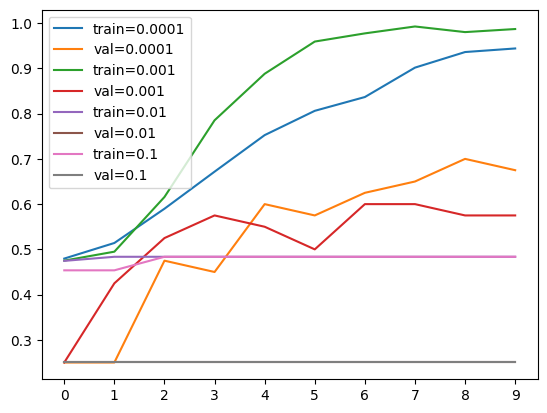

In [144]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
 
plt.xticks(np.arange(10))
plt.legend()

The learning rate of 0.0001 seems to be the best.

### Additional layers with different sizes

In [160]:
def make_model(learning_rate=0.01, size_inner=128):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Stack of convolutional layers and pooling layers
    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
    vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
    vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
    vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)
    # new
    conv_4 = keras.layers.Conv2D(filters=size_inner, kernel_size=(3, 3), activation='relu',)(vectors_3)
    vectors_4 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_4)
    # new_end

    # Flatten Layer
    flatten = keras.layers.Flatten()(vectors_4)

    # Fully Connected Layers
    # new
    dense_0 = keras.layers.Dense(size_inner, activation='relu')(flatten)
    # new_end
    dense_1 = keras.layers.Dense(256, activation='relu')(dense_0)
    dense_2 = keras.layers.Dense(128, activation='relu')(dense_1)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(dense_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [161]:
learning_rate = 0.001
 
scores = {}
 
for size in [128, 256, 512, 1024]:
    print(size)
 
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(
        train_generator, 
        epochs=10, 
        validation_data=test_generator)
    scores[size] = history.history
 
    print()
    print()

128
Epoch 1/10
89/89 [==============================] - 90s 975ms/step - loss: 1.2886 - accuracy: 0.4814 - val_loss: 1.4608 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 81s 910ms/step - loss: 1.2574 - accuracy: 0.4836 - val_loss: 1.4251 - val_accuracy: 0.2500
Epoch 3/10
89/89 [==============================] - 85s 947ms/step - loss: 1.2212 - accuracy: 0.4876 - val_loss: 1.4360 - val_accuracy: 0.2750
Epoch 4/10
89/89 [==============================] - 79s 878ms/step - loss: 1.1580 - accuracy: 0.4960 - val_loss: 1.4020 - val_accuracy: 0.3250
Epoch 5/10
89/89 [==============================] - 76s 846ms/step - loss: 1.0404 - accuracy: 0.5537 - val_loss: 1.0810 - val_accuracy: 0.5250
Epoch 6/10
89/89 [==============================] - 74s 835ms/step - loss: 0.8892 - accuracy: 0.6243 - val_loss: 1.2037 - val_accuracy: 0.5500
Epoch 7/10
89/89 [==============================] - 58s 643ms/step - loss: 0.7016 - accuracy: 0.7220 - val_loss: 0.9739 - val_accuracy: 0.

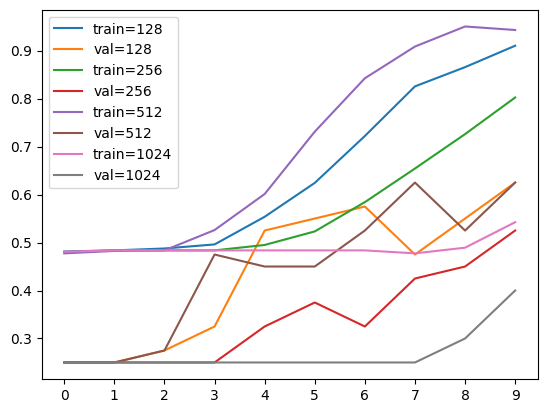

In [162]:
for size, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % size))
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
 
plt.xticks(np.arange(10))
plt.legend()

### Trying VGG-16 like architecture

Simply adding more layers makes no sense. Maybe the architecture should be changed. There are architectures called VGG 16 and VGG 19. I used some blocks here an try to improve my results. Let's see what happens...

In [163]:
def make_model_vgg(learning_rate=0.001):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Block 1
    conv_1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(base)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(conv_1)
    pool_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    # Block 2
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(pool_1)
    conv_4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(conv_3)
    pool_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_4)
    
    # Block 3
    conv_5 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(pool_2)
    conv_6 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_5)
    conv_7 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_6)
    conv_8 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_7)
    pool_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_8)

    # Block 4 (actually there is another Block 5 that is equal to Block 4)
    conv_9 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu',)(pool_3)
    conv_10 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu',)(conv_9)
    conv_11 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu',)(conv_10)
    conv_12 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu',)(conv_11)
    pool_4 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_12)

    # Flatten Layer
    flatten = keras.layers.Flatten()(pool_4)

    # Fully Connected Layers (actually this 1.024 is 4.096)
    dense_1 = keras.layers.Dense(1024, activation='relu')(flatten)
    dense_2 = keras.layers.Dense(1024, activation='relu')(dense_1)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(dense_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
load_img('./../Images/vgg_model.jpg')

In [164]:
model = make_model_vgg(learning_rate=0.001)
history = model.fit(
    train_generator, 
    epochs=10, 
    validation_data=test_generator)

Epoch 1/10
89/89 [==============================] - 641s 7s/step - loss: 3.1462 - accuracy: 0.4723 - val_loss: 1.4835 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 495s 6s/step - loss: 1.2598 - accuracy: 0.4836 - val_loss: 1.4673 - val_accuracy: 0.2500
Epoch 3/10
89/89 [==============================] - 499s 6s/step - loss: 1.2558 - accuracy: 0.4836 - val_loss: 1.4893 - val_accuracy: 0.2500
Epoch 4/10
89/89 [==============================] - 643s 7s/step - loss: 1.2574 - accuracy: 0.4836 - val_loss: 1.5053 - val_accuracy: 0.2500
Epoch 5/10
89/89 [==============================] - 634s 7s/step - loss: 1.2560 - accuracy: 0.4836 - val_loss: 1.5469 - val_accuracy: 0.2500
Epoch 6/10
89/89 [==============================] - 709s 8s/step - loss: 1.2539 - accuracy: 0.4836 - val_loss: 1.4960 - val_accuracy: 0.2500
Epoch 7/10
89/89 [==============================] - 645s 7s/step - loss: 1.2582 - accuracy: 0.4836 - val_loss: 1.4890 - val_accuracy: 0.2500
Epoch 8/10
89

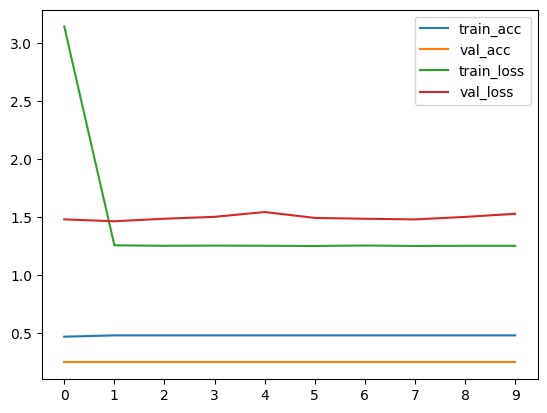

In [165]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xticks(np.arange(10))
plt.legend()

In [166]:
def make_model_vgg_small(learning_rate=0.001):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Block 1
    conv_1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(base)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(conv_1)
    pool_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    # Block 2
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(pool_1)
    conv_4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(conv_3)
    pool_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_4)
    
    # Block 3
    conv_5 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(pool_2)
    conv_6 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_5)
    conv_7 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_6)
    conv_8 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu',)(conv_7)
    pool_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_8)

    # Flatten Layer
    flatten = keras.layers.Flatten()(pool_3)

    # Fully Connected Layers (actually this 1.024 is 4.096)
    dense_1 = keras.layers.Dense(1024, activation='relu')(flatten)
    dense_2 = keras.layers.Dense(1024, activation='relu')(dense_1)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(dense_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
load_img('./../Images/vgg_small_model.jpg')

In [167]:
model_small = make_model_vgg_small(learning_rate=0.001)
history = model_small.fit(
    train_generator, 
    epochs=10, 
    validation_data=test_generator)

Epoch 1/10
89/89 [==============================] - 370s 4s/step - loss: 1.2953 - accuracy: 0.4751 - val_loss: 1.4452 - val_accuracy: 0.2500
Epoch 2/10
89/89 [==============================] - 358s 4s/step - loss: 1.2672 - accuracy: 0.4836 - val_loss: 1.5635 - val_accuracy: 0.2500
Epoch 3/10
89/89 [==============================] - 358s 4s/step - loss: 1.2612 - accuracy: 0.4836 - val_loss: 1.5336 - val_accuracy: 0.2500
Epoch 4/10
89/89 [==============================] - 366s 4s/step - loss: 1.2633 - accuracy: 0.4836 - val_loss: 1.6292 - val_accuracy: 0.2500
Epoch 5/10
89/89 [==============================] - 362s 4s/step - loss: 1.2603 - accuracy: 0.4836 - val_loss: 1.5053 - val_accuracy: 0.2500
Epoch 6/10
89/89 [==============================] - 359s 4s/step - loss: 1.2553 - accuracy: 0.4836 - val_loss: 1.5089 - val_accuracy: 0.2500
Epoch 7/10
89/89 [==============================] - 358s 4s/step - loss: 1.2564 - accuracy: 0.4836 - val_loss: 1.4988 - val_accuracy: 0.2500
Epoch 8/10
89

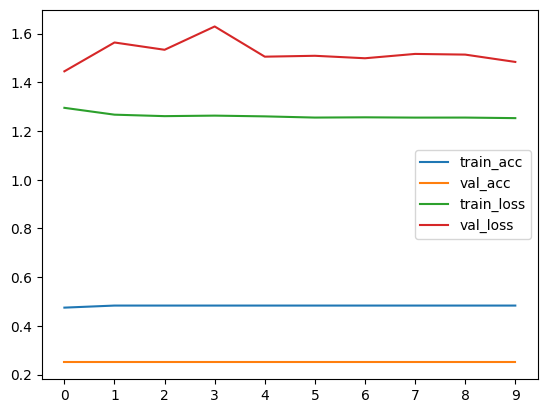

In [168]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xticks(np.arange(10))
plt.legend()

Both experiments were not successful. A validation accuracy of 25% is really bad. Let's try something different.

### Dropout

In [169]:
def make_model(learning_rate=0.001, dropout_rate=0.5):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Stack of convolutional layers and pooling layers
    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
    vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
    vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
    vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    # Flatten Layer
    flatten = keras.layers.Flatten()(vectors_3)

    # Fully Connected Layers
    dense_1 = keras.layers.Dense(256, activation='relu')(flatten)
    drop_1 = keras.layers.Dropout(dropout_rate)(dense_1)
    dense_2 = keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = keras.layers.Dropout(dropout_rate)(dense_2)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(drop_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [170]:
learning_rate = 0.001
scores = {}

for droprate in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        dropout_rate=droprate
    )

    history = model.fit(train_generator, epochs=30, validation_data=test_generator)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
89/89 [==============================] - 98s 1s/step - loss: 1.2572 - accuracy: 0.4791 - val_loss: 1.5862 - val_accuracy: 0.2500
Epoch 2/30
89/89 [==============================] - 99s 1s/step - loss: 1.0593 - accuracy: 0.5554 - val_loss: 1.3391 - val_accuracy: 0.3750
Epoch 3/30
89/89 [==============================] - 104s 1s/step - loss: 0.7013 - accuracy: 0.7266 - val_loss: 1.0906 - val_accuracy: 0.5500
Epoch 4/30
89/89 [==============================] - 102s 1s/step - loss: 0.3610 - accuracy: 0.8621 - val_loss: 2.2396 - val_accuracy: 0.3500
Epoch 5/30
89/89 [==============================] - 111s 1s/step - loss: 0.1699 - accuracy: 0.9390 - val_loss: 1.6850 - val_accuracy: 0.5750
Epoch 6/30
89/89 [==============================] - 100s 1s/step - loss: 0.1239 - accuracy: 0.9605 - val_loss: 1.8511 - val_accuracy: 0.5000
Epoch 7/30
89/89 [==============================] - 88s 985ms/step - loss: 0.0887 - accuracy: 0.9757 - val_loss: 2.4551 - val_accuracy: 0.5000
Epoch 8/3

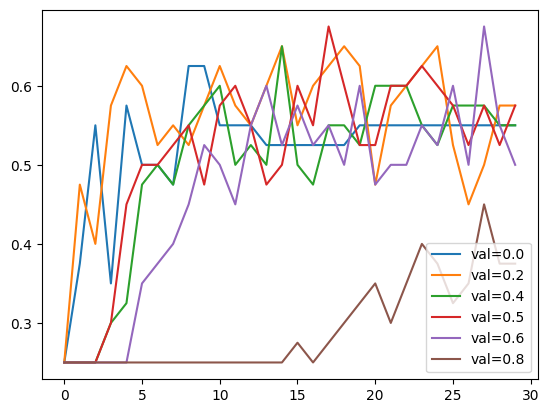

In [171]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.legend()

### Data Augmentation

In [172]:
def get_ImageDataGenerators():

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=10,
        height_shift_range=10,
        shear_range=10,
        zoom_range=0.1,
        cval=0.0,
        horizontal_flip=False,
        vertical_flip=True,
    )

    train_generator = train_gen.flow_from_directory(
        './../Data/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    test_generator = test_gen.flow_from_directory(
        './../Data/test',
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical'
    )

    return train_generator, test_generator

In [173]:
train_generator, test_generator = get_ImageDataGenerators()

learning_rate = 0.001
droprate = 0.5

model = make_model(
    learning_rate=learning_rate,
    dropout_rate=droprate
)

history = model.fit(train_generator, epochs=50, validation_data=test_generator)

Found 1770 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Epoch 1/50
89/89 [==============================] - 69s 744ms/step - loss: 1.3207 - accuracy: 0.4576 - val_loss: 1.5520 - val_accuracy: 0.2500
Epoch 2/50
89/89 [==============================] - 64s 712ms/step - loss: 1.2791 - accuracy: 0.4831 - val_loss: 1.4567 - val_accuracy: 0.2500
Epoch 3/50
89/89 [==============================] - 64s 708ms/step - loss: 1.2716 - accuracy: 0.4842 - val_loss: 1.4402 - val_accuracy: 0.2500
Epoch 4/50
89/89 [==============================] - 62s 689ms/step - loss: 1.2644 - accuracy: 0.4836 - val_loss: 1.4337 - val_accuracy: 0.2500
Epoch 5/50
89/89 [==============================] - 63s 706ms/step - loss: 1.2591 - accuracy: 0.4836 - val_loss: 1.4379 - val_accuracy: 0.2500
Epoch 6/50
89/89 [==============================] - 64s 718ms/step - loss: 1.2506 - accuracy: 0.4836 - val_loss: 1.4556 - val_accuracy: 0.2500
Epoch 7/50
89/89 [==============================] - 65s 724m

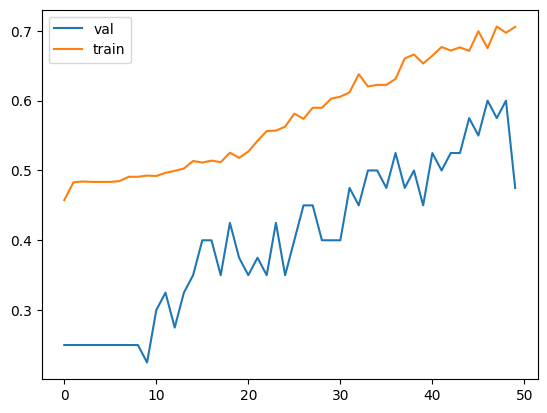

In [174]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Improving accuracy by increasing input quality
I want to check whether it's possible to increase detection accuracy by ignoring images with a size less than 20kb. Because of that I also have to exchange one A400M image in the test folder. The best validation accuracy after 75 epochs with activated data augmentation was 60%. The best performance I reached without augmentation but with using dropout of 50% (60% as well). Here the accuracy on validation data was 67.5%.  


In [16]:
def make_model(train_generator, learning_rate=0.001, dropout_rate=0.5):
    input_size=150
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Stack of convolutional layers and pooling layers
    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
    vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
    vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
    vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    # Flatten Layer
    flatten = keras.layers.Flatten()(vectors_3)

    # Fully Connected Layers
    dense_1 = keras.layers.Dense(256, activation='relu')(flatten)
    drop_1 = keras.layers.Dropout(dropout_rate)(dense_1)
    dense_2 = keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = keras.layers.Dropout(dropout_rate)(dense_2)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(drop_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [17]:
def get_ImageDataGenerators():

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=10,
        height_shift_range=10,
        shear_range=10,
        zoom_range=0.1,
        cval=0.0,
        horizontal_flip=False,
        vertical_flip=True,
    )

    train_generator = train_gen.flow_from_directory(
        './../Data/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    test_generator = test_gen.flow_from_directory(
        './../Data/test',
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical'
    )

    return train_generator, test_generator

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'sequential_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [19]:
train_generator_150, test_generator_150 = get_ImageDataGenerators()

learning_rate = 0.001
droprate = 0.5

model_150 = make_model(
    train_generator=train_generator_150,
    learning_rate=learning_rate,
    dropout_rate=droprate
)

history_150 = model_150.fit(
    train_generator_150, 
    epochs=75, 
    validation_data=test_generator_150,
    callbacks=[checkpoint]
)

Found 1005 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


Epoch 1/75
51/51 [==============================] - ETA: 0s - loss: 1.3621 - accuracy: 0.4000

/home/peter/ML_Zoomcamp2023_Capstone1/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 87s 2s/step - loss: 1.3621 - accuracy: 0.4000 - val_loss: 1.4469 - val_accuracy: 0.2500
Epoch 2/75
51/51 [==============================] - 78s 2s/step - loss: 1.3212 - accuracy: 0.4239 - val_loss: 1.4330 - val_accuracy: 0.2500
Epoch 3/75
51/51 [==============================] - 75s 1s/step - loss: 1.3097 - accuracy: 0.4279 - val_loss: 1.4943 - val_accuracy: 0.2500
Epoch 4/75
51/51 [==============================] - 74s 1s/step - loss: 1.2979 - accuracy: 0.4308 - val_loss: 1.4461 - val_accuracy: 0.2500
Epoch 5/75
51/51 [==============================] - 73s 1s/step - loss: 1.2856 - accuracy: 0.4308 - val_loss: 1.5321 - val_accuracy: 0.2500
Epoch 6/75
51/51 [==============================] - 75s 1s/step - loss: 1.2869 - accuracy: 0.4308 - val_loss: 1.4380 - val_accuracy: 0.2500
Epoch 7/75
51/51 [==============================] - 68s 1s/step - loss: 1.2808 - accuracy: 0.4299 - val_loss: 1.4809 - val_accuracy: 0.2500
Epoch 8/75
51/51 [=============

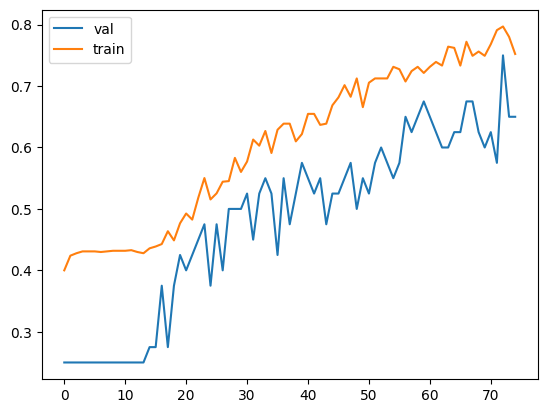

In [20]:
hist = history_150.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

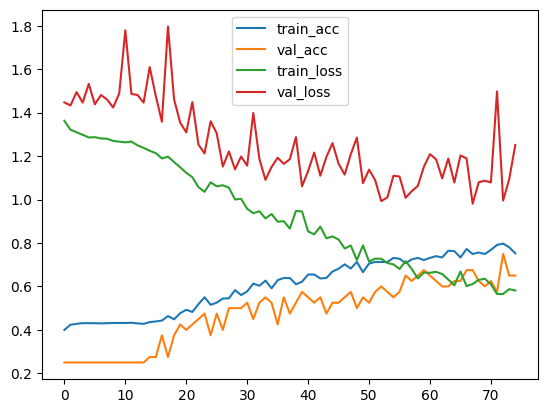

In [23]:
hist = history_150.history
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()

The last experiment using data augmentation was not very efficient. The model could reach an accuracy of 75% on validation dataset (which is the best performance) but it needs more than 70 epochs for that. Comparing to the current best model it could reach the performance of 67.5% after 60 epochs, which is worse than the current best model. Let's try one last augmentation parameter set and compare the first 30 epochs. I'm not really expecting a better performance. On the last plot the train loss is decreasing all the time while the accuracy on training data and validation data is increasing (slowly). That is good. But around epoch number 50 the loss value on the validation data is stagnating which is not good.

In [24]:
def get_ImageDataGenerators():

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=10,
        height_shift_range=10,
        #shear_range=10,
        zoom_range=0.1,
        #cval=0.0,
        horizontal_flip=False,
        vertical_flip=True,
    )

    train_generator = train_gen.flow_from_directory(
        './../Data/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    test_generator = test_gen.flow_from_directory(
        './../Data/test',
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical'
    )

    return train_generator, test_generator

In [25]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'sequential_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [26]:
train_generator_150, test_generator_150 = get_ImageDataGenerators()

learning_rate = 0.001
droprate = 0.5

model_150 = make_model(
    train_generator=train_generator_150,
    learning_rate=learning_rate,
    dropout_rate=droprate
)

history_150 = model_150.fit(
    train_generator_150, 
    epochs=30, 
    validation_data=test_generator_150,
    callbacks=[checkpoint]
)

Found 1005 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.3891

/home/peter/ML_Zoomcamp2023_Capstone1/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 81s 2s/step - loss: 1.3930 - accuracy: 0.3891 - val_loss: 1.4768 - val_accuracy: 0.2500
Epoch 2/30
51/51 [==============================] - 76s 1s/step - loss: 1.3071 - accuracy: 0.4348 - val_loss: 1.4867 - val_accuracy: 0.2500
Epoch 3/30
51/51 [==============================] - 75s 1s/step - loss: 1.2949 - accuracy: 0.4269 - val_loss: 1.4164 - val_accuracy: 0.2500
Epoch 4/30
51/51 [==============================] - 74s 1s/step - loss: 1.3020 - accuracy: 0.4239 - val_loss: 1.4858 - val_accuracy: 0.2500
Epoch 5/30
51/51 [==============================] - 73s 1s/step - loss: 1.2948 - accuracy: 0.4318 - val_loss: 1.5127 - val_accuracy: 0.2500
Epoch 6/30
51/51 [==============================] - 76s 1s/step - loss: 1.2889 - accuracy: 0.4308 - val_loss: 1.3966 - val_accuracy: 0.2500
Epoch 7/30
51/51 [==============================] - 73s 1s/step - loss: 1.2794 - accuracy: 0.4299 - val_loss: 1.4195 - val_accuracy: 0.2500
Epoch 8/30
51/51 [=============

## Selecting the best model and retrain on 299x299

The experiments have shown that the decreased image set (using only images with a size > 20KB) was not very helpful -same for using augmentation. To train the best model I use all images and don't use any augmentation, because that seems to be the best setup in my case.

In [27]:
def make_model(train_generator, learning_rate=0.001, dropout_rate=0.5):
    input_size=299
    
    base_model = keras.models.Sequential()
    classes = len(list(train_generator.class_indices.keys()))

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)

    #############################################################################################

    # Stack of convolutional layers and pooling layers
    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',)(base)
    vectors_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',)(vectors_1)
    vectors_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',)(vectors_2)
    vectors_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    # Flatten Layer
    flatten = keras.layers.Flatten()(vectors_3)

    # Fully Connected Layers
    dense_1 = keras.layers.Dense(256, activation='relu')(flatten)
    drop_1 = keras.layers.Dropout(dropout_rate)(dense_1)
    dense_2 = keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = keras.layers.Dropout(dropout_rate)(dense_2)

    # Output Layer
    outputs = keras.layers.Dense(classes, activation='softmax')(drop_2)

    #############################################################################################

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [28]:
def get_ImageDataGenerators():

    train_gen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=30,
        #width_shift_range=10,
        #height_shift_range=10,
        #shear_range=10,
        #zoom_range=0.1,
        #cval=0.0,
        #horizontal_flip=False,
        #vertical_flip=True,
    )

    train_generator = train_gen.flow_from_directory(
        './../Data/train',
        target_size=(299, 299),
        batch_size=20,
        class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    test_generator = test_gen.flow_from_directory(
        './../Data/test',
        target_size=(299, 299),
        batch_size=20,
        shuffle=False,
        class_mode='categorical'
    )

    return train_generator, test_generator

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'sequential_final_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [31]:
train_generator_299, test_generator_299 = get_ImageDataGenerators()

learning_rate = 0.001
droprate = 0.5

model = make_model(
    train_generator=train_generator_299, 
    learning_rate=learning_rate,
    dropout_rate=droprate
)

history = model.fit(
    train_generator_299, 
    epochs=75, 
    validation_data=test_generator_299,
    callbacks=[checkpoint]
)

Found 1770 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


Epoch 1/75
89/89 [==============================] - 374s 4s/step - loss: 1.4474 - accuracy: 0.4531 - val_loss: 1.5142 - val_accuracy: 0.2500
Epoch 2/75
89/89 [==============================] - 239s 3s/step - loss: 1.2688 - accuracy: 0.4842 - val_loss: 1.4341 - val_accuracy: 0.2500
Epoch 3/75
89/89 [==============================] - 343s 4s/step - loss: 1.2357 - accuracy: 0.4853 - val_loss: 1.4267 - val_accuracy: 0.3000
Epoch 4/75
89/89 [==============================] - 240s 3s/step - loss: 1.1064 - accuracy: 0.5345 - val_loss: 1.3052 - val_accuracy: 0.3250
Epoch 5/75
89/89 [==============================] - 366s 4s/step - loss: 0.8940 - accuracy: 0.6322 - val_loss: 1.2945 - val_accuracy: 0.3500
Epoch 6/75
89/89 [==============================] - 347s 4s/step - loss: 0.6072 - accuracy: 0.7774 - val_loss: 1.0095 - val_accuracy: 0.6250
Epoch 7/75
89/89 [==============================] - 377s 4s/step - loss: 0.3812 - accuracy: 0.8780 - val_loss: 1.0696 - val_accuracy: 0.5750
Epoch 8/75
89

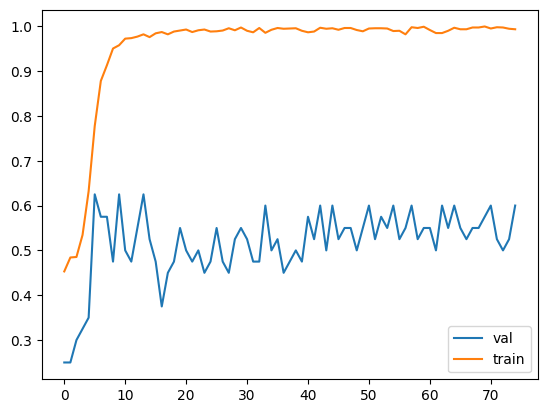

In [32]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Save the model

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'improvedSequential_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

## Load and test the model

In [ ]:
with open('heart-model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [ ]:
def predict_single_patient(patient, dv, model):
    X = dv.transform([patient])
    y_pred = model.predict_proba(X)[:,1]
    score = int(y_pred[0] >= 0.50)
    return score

In [ ]:
print(df_test.iloc[0])
print(y_test[0])

In [ ]:
patient = df_test.iloc[0]
predict_single_patient(patient, dv, model)